## Analysis of NBA Preseason Championship Odds and Over Unders

In [486]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns

### Bring in data and get an overview
Data from [basketball-reference.com](https://www.basketball-reference.com)

In [2]:
df = pd.read_csv('data/nba_odds.csv')
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             990 non-null    object 
 1   team             990 non-null    object 
 2   odds             990 non-null    int64  
 3   wins_over_under  478 non-null    float64
 4   actual_record    478 non-null    object 
 5   result           478 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 46.5+ KB
None


,year,team,odds,wins_over_under,actual_record,result
0,1984-85,Boston Celtics,200,NaN,NaN,NaN
1,1984-85,Los Angeles Lakers,200,NaN,NaN,NaN


In [3]:
df.describe()

,odds,wins_over_under
count,990.000000,478.000000
mean,12410.981818,40.903766
std,33461.572698,10.382928
min,-187.000000,16.000000
25%,1500.000000,33.500000
50%,4000.000000,41.500000
75%,10000.000000,48.500000
max,500000.000000,67.500000


### Clean and add needed extra columns
* Seperate City and Mascot name

In [4]:
df['mascot'] = df['team'].str.extract('(\w+)$')
df['city'] = df['team'].str.extract('^(.*?)\w+$')
print('Teams Names in data:', len(df.groupby('team').count()))
print('Cities in data:', len(df.groupby('city').count()))
print('Mascots in data:', len(df.groupby('mascot').count()))

Teams Names in data: 38
Cities in data: 34
Mascots in data: 33


* New columns for combined team names
    * Combine multiple franchises based on missing years that match up

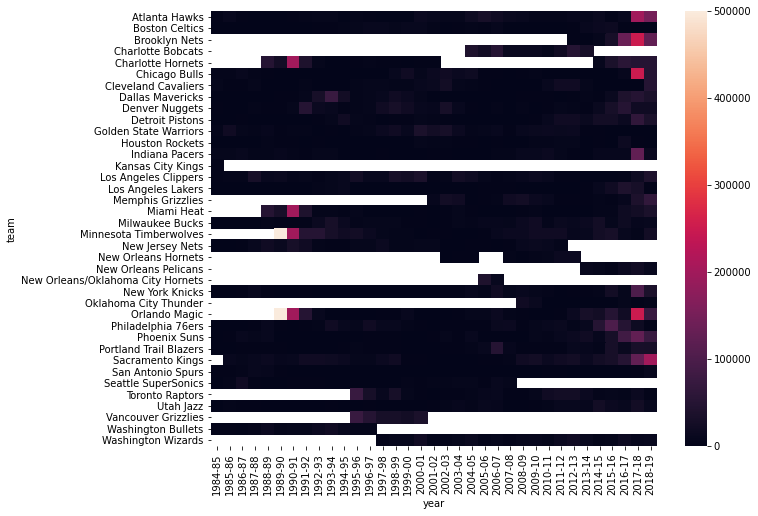

In [5]:
# Use heatmap to visualize which team names should be combined so no overlap is introduced
plt.figure(figsize=(10,8))
piv1 = df.groupby(['team','year']).mean().unstack()['odds']
sns.heatmap(piv1)
plt.show()

In [6]:
# Map old names to new names
t1 = ['New Orleans Hornets', 'New Orleans/Oklahoma City Hornets']
d1 = dict.fromkeys(t1,'New Orleans Pelicans')
d2 = {'Charlotte Bobcats': 'Charlotte Hornets', 'New Jersey Nets':'Brooklyn Nets','Kansas City Kings':'Sacramento Kings',
     'Vancouver Grizzlies':'Memphis Grizzlies','Seattle SuperSonics':'Oklahoma City Thunder','Washington Bullets':'Washington Wizards'}
d3 = {**d1, **d2}

df['team_alt'] = df['team'].map(d3)
df['team_alt'] = df['team_alt'].fillna(df['team'])

print('Teams Names in data:', len(df.groupby('team_alt').count()))

Teams Names in data: 30


* Add column for yearly champions

In [7]:
# Bring in champion data
cdf = pd.read_csv('data/champs.csv')
cdf.head(2)

,year_id,lg_id,champion,runnerup,mvp_finals,pts_leader_name,pts_leader_name_val,trb_leader_name,trb_leader_name_val,ast_leader_name,ast_leader_name_val,ws_leader_name,ws_leader_name_val
0,2019,NBA,Toronto Raptors,Golden State Warriors,K. Leonard,K. Leonard,732,D. Green,223,D. Green,187,K. Leonard,4.9
1,2018,NBA,Golden State Warriors,Cleveland Cavaliers,K. Durant,L. James,748,D. Green,222,L. James,198,L. James,5.2


In [8]:
# Combine new data
cdf1 = cdf[['year_id', 'champion']].copy()
cdf1['year_id'] = pd.to_numeric(cdf1['year_id'])
cdf1.loc[:,'champ'] = True

# Change year format
s = [f'20{i}' if int(i) < 20 else f'19{i}' for i in df['year'].str[-2:]]
df['yearNumeric'] = pd.to_numeric(s)
df.head()

# Join datasets
df1 = df.merge(cdf1, how='outer', left_on=['yearNumeric','team'], right_on=['year_id','champion'])
df1 = df1.dropna(subset=['year'])

# If year and team match, count 1

* Column for amount won/lost if betting \\$100 on champ
* Column for amount to bet to win \\$100

In [211]:
def calcWinnings(row):
    if row['champ'] == True:
        if np.sign(row['odds']) < 0:
            return (-100 / (row['odds'] / 100))
        else:
            return (100 * (row['odds'] / 100))
    return -100

def calcToWin100(row):
    ''' Calculate how much you would have had to bet to win $100'''
    return abs(10000/row['odds'])

df1['winnings1'] = df1.apply(calcWinnings, axis=1)
df1['toWin100'] = df1.apply(calcToWin100, axis=1)
df1['winnings100'] = -df1['toWin100']
df1['winnings100'][df1['champ']==True] = df1['toWin100']
df1.head(2)

<ipython-input-211-19fb9b373c55>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['winnings100'][df1['champ']==True] = df1['toWin100']


,year,team,odds,wins_over_under,actual_record,result,mascot,city,team_alt,yearNumeric,year_id,champion,champ,winnings1,toWin100,winnings100
0,1984-85,Boston Celtics,200.0,NaN,NaN,NaN,Celtics,Boston,Boston Celtics,1985.0,NaN,NaN,NaN,-100.0,50.0,-50.0
1,1984-85,Los Angeles Lakers,200.0,NaN,NaN,NaN,Lakers,Los Angeles,Los Angeles Lakers,1985.0,1985.0,Los Angeles Lakers,True,200.0,50.0,50.0


In [212]:
grouped = df1.groupby('team_alt').sum()
grouped.head()

,odds,wins_over_under,yearNumeric,year_id,winnings1,toWin100,winnings100
team_alt,,,,,,,
Atlanta Hawks,585700.0,591.5,70070.0,0.0,-3500.0,108.877423,-108.877423
Boston Celtics,147280.0,737.0,70070.0,3994.0,-2050.0,368.111358,-268.111358
Brooklyn Nets,756200.0,593.0,70070.0,0.0,-3500.0,105.940539,-105.940539
Charlotte Hornets,797900.0,465.5,58117.0,0.0,-2900.0,61.954609,-61.954609
Chicago Bulls,465410.0,684.0,70070.0,11967.0,-1240.0,472.624199,202.613896


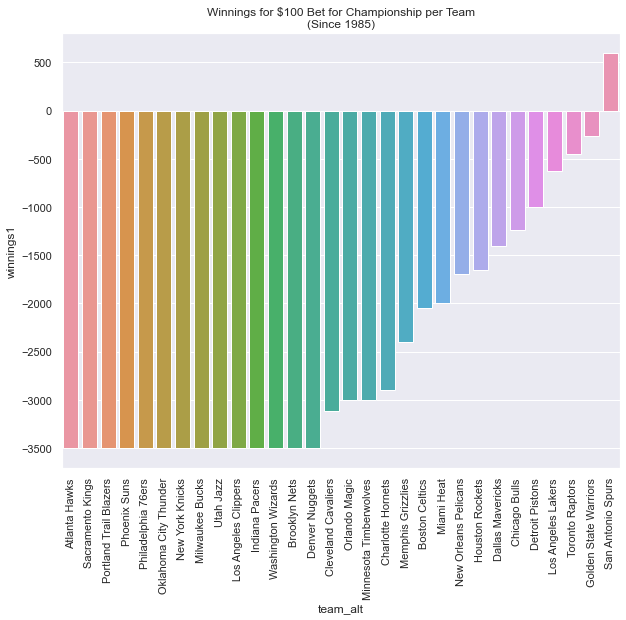

In [213]:
plt.figure(figsize=(10,8))
sns.set_style('darkgrid', {})
idx = grouped.sort_values(by='winnings1').index

ax = sns.barplot(data=grouped.sort_values(by='winnings1'), x=idx, y='winnings1')
ax.set_xticklabels(labels=idx, rotation=90)
ax.set_yticks(ticks=range(-3500,1000,500))

ax.set_title('Winnings for $100 Bet for Championship per Team\n(Since 1985)')
plt.show()

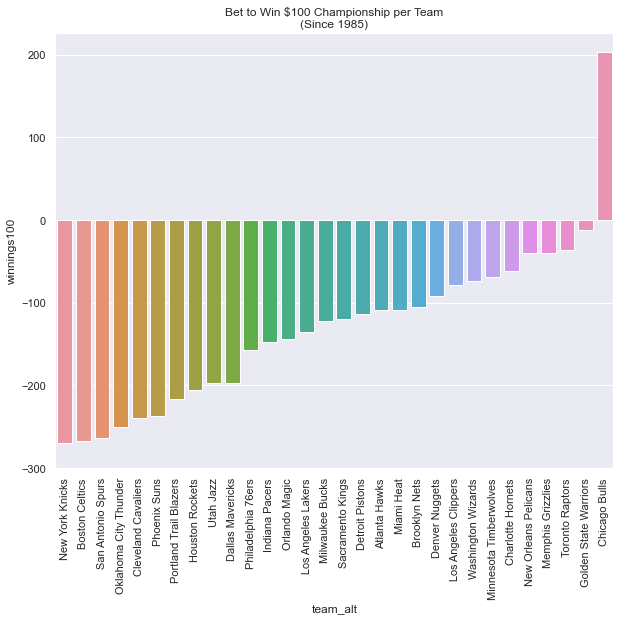

In [216]:
fig = plt.figure(figsize=(10,8))
idx = grouped.sort_values(by='winnings100').index

ax = sns.barplot(data=grouped.sort_values(by='winnings100'), x=idx, y='winnings100')
ax.set_xticklabels(labels=idx, rotation=90)
ax.set_yticks(ticks=range(-300,300,100))

ax.set_title('Bet to Win $100 Championship per Team\n(Since 1985)')

plt.show()

### How much would you have won by betting on each positionally ranked team in the preasons?
(e.g. Betting on top ranked team each year, betting on 3rd ranked team each year, etc.)

In [248]:
df2 = df1[['yearNumeric','team_alt', 'odds', 'champ','winnings1','winnings100']]
df2 = df2.sort_values(by=['yearNumeric', 'odds'])
df2['yearRank'] = df2.groupby(['yearNumeric'])['odds'].rank(method='dense')

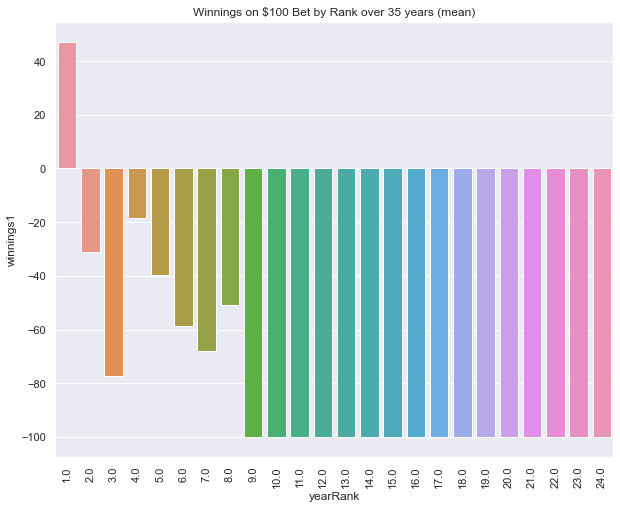

In [249]:
fig = plt.figure(figsize=(10,8))

data = df2.groupby('yearRank').mean()
idx = data.index

ax = sns.barplot(data=data, x=idx, y='winnings1')
ax.set_xticklabels(labels=idx, rotation=90)
# ax.set_yticks(ticks=range(-900,100,100))

ax.set_title('Winnings on $100 Bet by Rank over 35 years (mean)')

plt.show()

#### It looks like betting on 1st ranked teams has paid 
* Caveat: These depend on how you break ties in the ranking. This is set to rank the team the lowest possible, so if two teams are tied at first place, the next team or teams will be ranked 2nd. This is why mean score is used instead of sum, as that would put the later positions at a disadvantage.
* Using this method, one must put \\$100 on *each* team in the given rank

In [ ]:
# Break down rankings in yearly bins to see if handicapping has gotten better

In [250]:
# Find the total outlay vs return for 1st and 5th ranked teams
# This info is also easily accessed via dataframe manipulation, this just shows the math
outlay = 100 * len(df2[(df2['yearRank']==1)])
winners  = df2[(df2['yearRank']==1) & (df2['champ']==True)]['winnings1']
winnings = len(winners) * 100 + winners.sum()
profit = winnings - outlay
roi = profit / outlay
print(roi)

0.47278971995496777


In [263]:
yearly = df2[(df2['yearRank']==1)].copy()
yg = yearly.groupby('yearNumeric').sum()

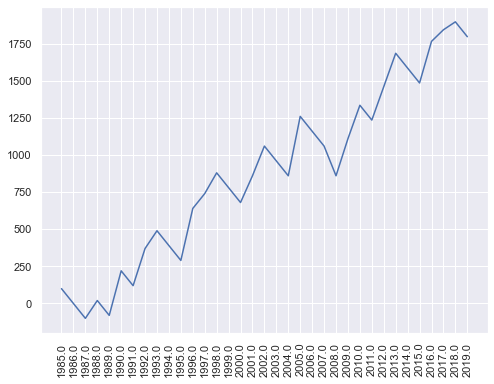

In [266]:
fig = plt.figure(figsize=(8,6))
data = yg['winnings1'].cumsum()
idx = data.index
ax = sns.lineplot(data=data)
ax.set_xticklabels(labels=idx, rotation=90)
ax.set_xticks(ticks=data.index)
plt.show()

Betting on the first place team/s every year has averaged a 47% return over the last 35 years.
What if you only spent \\$100 a year, even if there were teams tied in the position?

In [273]:
(yg['winnings1'] / yg['yearRank']).sum() / 3500

0.49188598166539343

In [279]:
# Setup function to get return for given position, rank method, bet split
def getPositionReturn(pos, df, rankMethod='dense', splitMethod='split'):
    new_df = df[['yearNumeric','team_alt', 'odds', 'champ','winnings1','winnings100']]
    new_df = new_df.sort_values(by=['yearNumeric', 'odds'])
    new_df['yearRank'] = df2.groupby(['yearNumeric'])['odds'].rank(method=rankMethod)
    profit = new_df[(new_df['yearRank']==pos)]['winnings1'].sum()
    outlay = ''
    return {'profit': '', 'outlay': '', 'roi':''}

getPositionReturn(1, df2)

1796.600935828877

In [435]:
## Setup a randomization of odds to win and then generate winner based on given odds to test different betting
## methods over randomized champions
s = df2['odds'].mask(df2['odds'] > 0, 100 / (df2['odds'] + 100))
s = s.mask(df2['odds'] < 0, -s / (-s + 100))
df2['prob'] = s * 100
# df2[df2['yearNumeric'] == 1985]

#### How did each team do against their projected win total each year?

In [334]:
wl = df[df['wins_over_under'].notna()].copy()
wl['wins'] = wl['actual_record'].str.extract(r'(\d+)')
wl.head(3)

,year,team,odds,wins_over_under,actual_record,result,mascot,city,team_alt,yearNumeric,wins
306,2002-03,Los Angeles Lakers,180,58.5,50-32,under,Lakers,Los Angeles,Los Angeles Lakers,2003,50
307,2003-04,Los Angeles Lakers,140,58.5,56-26,under,Lakers,Los Angeles,Los Angeles Lakers,2004,56
413,2005-06,San Antonio Spurs,250,58.5,63-19,over,Spurs,San Antonio,San Antonio Spurs,2006,63


In [412]:
c1 = wl[['team_alt','result']].groupby('team_alt')['result'].value_counts().unstack().reset_index().melt(id_vars=['team_alt'], value_vars=['over'])
c2 = wl[['team_alt','result']].groupby('team_alt')['result'].value_counts().unstack().reset_index().melt(id_vars=['team_alt'], value_vars=['under'])
c3 = pd.concat([c1,c2])
c3 = c3.sort_values('team_alt').reset_index(drop=True)

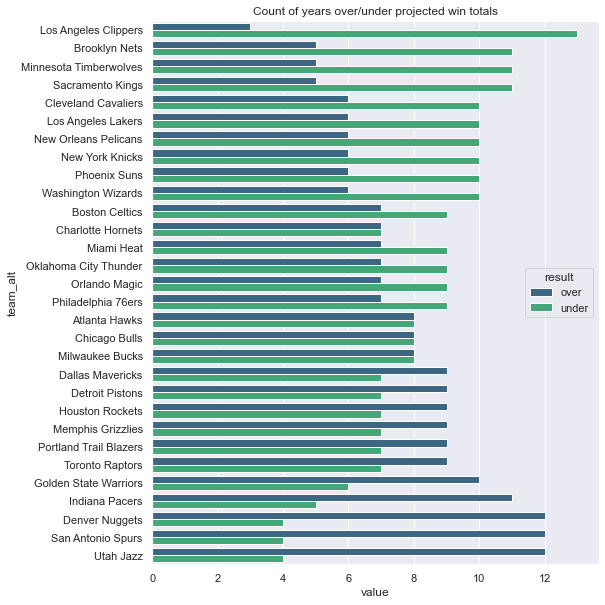

In [440]:
fig = plt.figure(figsize=(8,10))
data = c3.sort_values(['result','value'])
ax = sns.barplot(y='team_alt', x='value', hue='result', data=data, orient='h', palette='viridis')
ax.set_yticklabels(labels=data['team_alt'].unique())
ax.set_title('Count of years over/under projected win totals')
plt.show()

Get the mean and sum over/under for each team

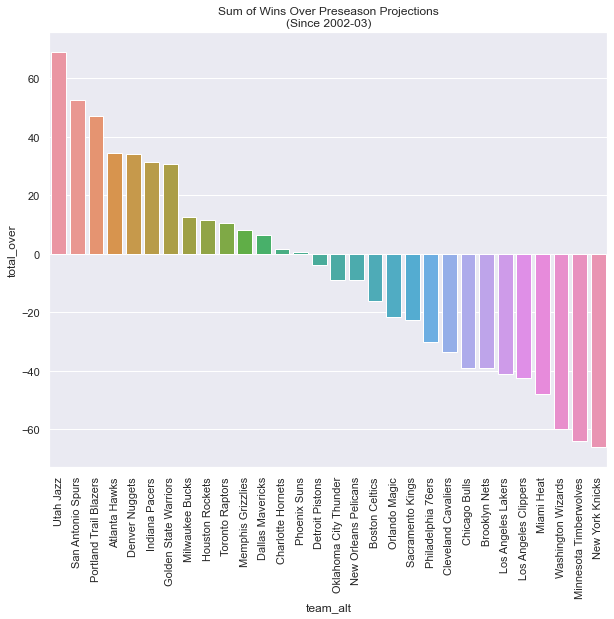

In [468]:
wl['total_over'] = pd.to_numeric(wl['wins']) - wl['wins_over_under']

fig = plt.figure(figsize=(10,8))

data = wl.groupby('team_alt').sum().sort_values('total_over', ascending=False)
idx = data.index

ax = sns.barplot(data=data, x=idx, y='total_over')
ax.set_xticklabels(labels=idx, rotation=90)
ax.set_title('Sum of Wins Over Preseason Projections\n(Since 2002-03)')

# for i, row in data.iterrows():
#     ax.text(row.name, row.total_over, 8)
    
plt.show()

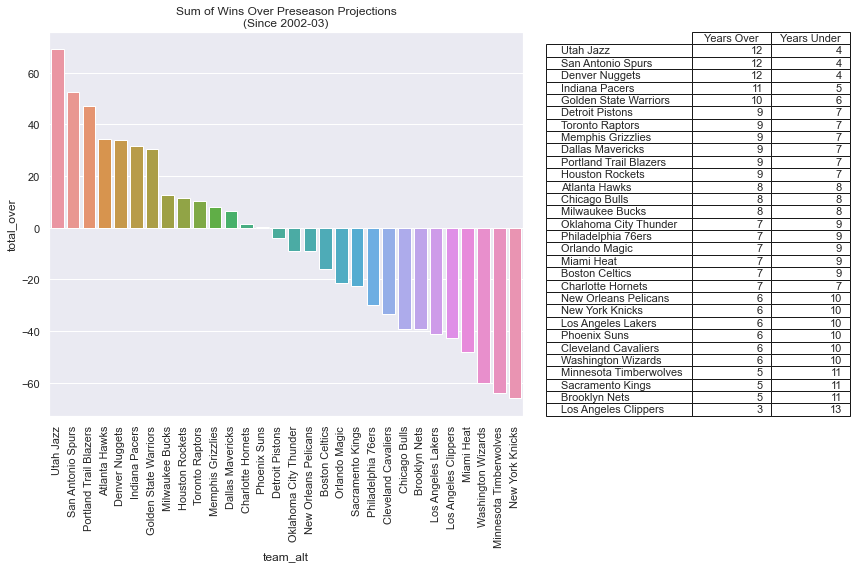

In [557]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8), gridspec_kw=dict(width_ratios=[3,1]))

data = wl.groupby('team_alt').sum().sort_values('total_over', ascending=False)
idx = data.index

sns.barplot(data=data, x=idx, y='total_over', ax=ax1)
ax1.set_xticklabels(labels=idx, rotation=90)
ax1.set_title('Sum of Wins Over Preseason Projections\n(Since 2002-03)')

tdf = wl.groupby('team_alt')['result'].value_counts().unstack().sort_values('over', ascending=False)
ax2.axis('off') 
mpl_table = ax2.table(cellText = tdf.values, rowLabels = tdf.index, bbox=[0,0,1,1], 
                      colLabels=['Years Over', 'Years Under'])
mpl_table.set_fontsize(12)

fig.tight_layout()
plt.show()

In [539]:
table = wl.groupby('team_alt')['result'].value_counts().unstack()
table['mean'] = wl.groupby('team_alt')['total_over'].mean().round(2)
table['median'] = wl.groupby('team_alt')['total_over'].median()
table['std'] = wl.groupby('team_alt')['total_over'].std().round(2)
table['best'] = wl.groupby('team_alt')['total_over'].max()
table['worst'] = wl.groupby('team_alt')['total_over'].min()
table = table.rename_axis(None)
table.columns.name = None
table.sort_values('over', ascending=False)

,over,under,mean,median,std,best,worst
Utah Jazz,12,4,4.31,5.00,6.92,16.5,-10.5
San Antonio Spurs,12,4,3.28,4.00,5.25,11.5,-8.0
Denver Nuggets,12,4,2.12,2.25,7.53,15.5,-12.0
Indiana Pacers,11,5,1.97,2.50,7.15,16.5,-11.5
Golden State Warriors,10,6,1.91,3.00,8.71,14.5,-9.5
Detroit Pistons,9,7,-0.25,1.00,7.95,12.5,-14.5
Toronto Raptors,9,7,0.66,0.50,9.37,14.5,-21.0
Memphis Grizzlies,9,7,0.50,1.00,9.86,18.5,-18.0
Dallas Mavericks,9,7,0.41,1.50,6.72,11.0,-11.5
Portland Trail Blazers,9,7,2.94,1.50,8.06,15.5,-9.5
